In [23]:
import pathlib
import os
import datetime
import time

import numpy as np
# import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model, utils, optimizers, losses
import tensorflow as tf
import matplotlib.pyplot as plt


In [24]:
# model expected shape=(None, 224, 224)
IMG_SIZE = (224, 224)
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
flowers_dir = 'small_flower_dataset/'
EPOCHS = 20

In [25]:
# base_model = MobileNetV2(
#         input_shape=(224, 224, 3),
#         alpha=1.0, include_top=True, weights="imagenet",
#         input_tensor=None, pooling=None,
#         classifier_activation="softmax"
#         )
# base_model.trainable = False

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze layer exclude new layer
for layer in base_model.layers:
    layer.trainable=False



In [26]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation='softmax')(x)
#flower_output = base_model.layers[-2].output

# A Denset layer of 5 classes
#outputs = layers.Dense(5, activation="relu", name="flower_power_layer")(flower_output)

flower_model = Model(inputs = base_model.inputs, outputs = outputs)


In [27]:
flower_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [28]:

batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
                flowers_dir,
                labels='inferred',
                label_mode='int',
                class_names=None,
                color_mode='rgb',
                batch_size=batch_size,
                image_size=IMG_SIZE,
                shuffle=True,
                seed=2,
                validation_split=0.2,
                subset="training",
                interpolation='bilinear',
                follow_links=False,
                crop_to_aspect_ratio=False)
val_ds = tf.keras.utils.image_dataset_from_directory(
                flowers_dir,
                labels='inferred',
                label_mode='int',
                class_names=None,
                color_mode='rgb',
                batch_size=batch_size,
                image_size=IMG_SIZE,
                shuffle=True,
                seed=2,
                validation_split=0.2,
                subset="validation",
                interpolation='bilinear',
                follow_links=False,
                crop_to_aspect_ratio=False)
class_names = train_ds.class_names


    # Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data
# The RGB channel values are in the [0, 255] range. 
# This is not ideal for a neural network; in general you should seek to make your input values small.
normalization_layer = layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = normalized_train_ds
val_ds = normalized_val_ds

Found 1000 files belonging to 5 classes.
Using 800 files for training.
Found 1000 files belonging to 5 classes.
Using 200 files for validation.


In [29]:

    # To freeze a layer, simply set its trainable property to False.
    #  We do this for all layers except the last one, which is our newly created output layer.

    
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

start = time.time()
    # Train model
flower_model.compile(
        optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
)
history = flower_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

    # end time
end = time.time()
print ("[STATUS] end time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
print ("[STATUS] duration: {}".format(end - start))
    

Epoch 1/20
25/25 [==============================] - 34s 1s/step - loss: 1.3744 - accuracy: 0.4512 - val_loss: 1.0472 - val_accuracy: 0.6700
Epoch 2/20
25/25 [==============================] - 26s 1s/step - loss: 0.8355 - accuracy: 0.7013 - val_loss: 0.8507 - val_accuracy: 0.6950
Epoch 3/20
25/25 [==============================] - 26s 1s/step - loss: 0.6504 - accuracy: 0.7763 - val_loss: 0.7267 - val_accuracy: 0.7600
Epoch 4/20
25/25 [==============================] - 28s 1s/step - loss: 0.5552 - accuracy: 0.8087 - val_loss: 0.6763 - val_accuracy: 0.7750
Epoch 5/20
25/25 [==============================] - 25s 995ms/step - loss: 0.4697 - accuracy: 0.8438 - val_loss: 0.6308 - val_accuracy: 0.7800
Epoch 6/20
25/25 [==============================] - 25s 989ms/step - loss: 0.4280 - accuracy: 0.8600 - val_loss: 0.6160 - val_accuracy: 0.7950
Epoch 7/20
25/25 [==============================] - 23s 930ms/step - loss: 0.3849 - accuracy: 0.8750 - val_loss: 0.5949 - val_accuracy: 0.8000
Epoch 8/20


<Figure size 576x576 with 0 Axes>

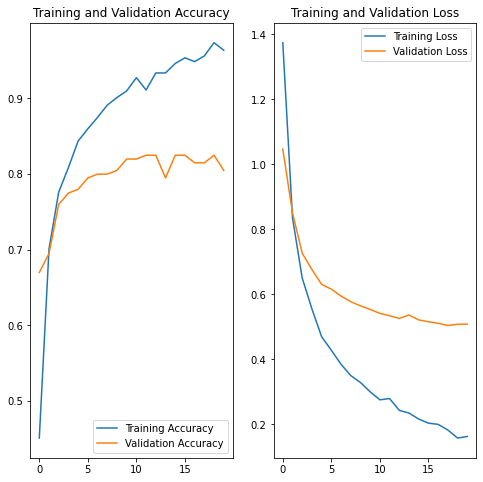

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
# if __name__ == '__main__':
#     import_model = task_2()
#     flower_model = task_3(import_model)
#     flower_model.summary()
#     train_ds, val_ds = task_4()
#     history = task_5(flower_model, train_ds, val_ds)
#     task_6(history)